In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import momentumopt
from quadruped.quadruped_wrapper import QuadrupedWrapper
from quadruped.simulator import Simulator

import pybullet as p
import time
import tsid
import os
import pinocchio as se3
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm

np.set_printoptions(suppress=True, precision=2)

In [2]:
def read_data(filename):
    return np.genfromtxt(filename)[:, 1:]

desired = {
    'q': read_data('quadruped_generalized_positions.dat'),
    'dq': read_data('quadruped_generalized_velocities.dat'),
    'ddq': read_data('quadruped_generalized_acceleration.dat'),
    'forces': read_data('quadruped_forces.dat')
}

desired['q'][:, 2] += 0.34

urdf_path = '../src/urdf/quadruped.urdf'
urdf_model_path = '../src/urdf/'
urdf_base_string = '../src'
robot_display = QuadrupedWrapper(urdf_path)

def base_pos_vec(q):
    arr = q[3:7]
    quad = se3.Quaternion(arr[3], arr[0], arr[1], arr[2])

    return np.vstack([
        q[:3].reshape(-1, 1),
        se3.utils.matrixToRpy(quad.matrix())
    ])

# for iq in q[::17]:
#     robot.display(iq.reshape(-1, 1))

/home/jviereck/dev/kino-dynamic-opt/src/catkin/motion_planning/momentumopt/src/quadruped/quadruped_wrapper.py:44: DeprecatedWarning: Using deprecated instance variable Model.neutralConfiguration. Please use Model.referenceConfigurations instead.
  self.q = self.robot.model.neutralConfiguration.copy()


In [3]:
class PyBulletSimulator(Simulator):
    def __init__(self, robot):
        physicsClient = p.connect(p.GUI)
        # physicsClient = p.connect(p.DIRECT)

        planeId = p.loadURDF(urdf_base_string + "/urdf/plane_with_restitution.urdf")
        cubeStartPos = [0,0,0.30]
        cubeStartOrientation = p.getQuaternionFromEuler([0,0,0])
        self.robotId = p.loadURDF(urdf_base_string + "/urdf/quadruped.urdf",cubeStartPos, cubeStartOrientation, flags=p.URDF_USE_INERTIA_FROM_FILE)
        cubePos, cubeOrn = p.getBasePositionAndOrientation(self.robotId)

        useRealTimeSimulation = False

        # Query all the joints.
        num_joints = p.getNumJoints(self.robotId)
        print("Number of joints={}".format(num_joints))

        for ji in range(num_joints):
            p.changeDynamics(self.robotId, ji, linearDamping=.04, angularDamping=0.04, restitution=0.0, lateralFriction=0.5)

        p.setGravity(0,0, -9.81)
        p.setPhysicsEngineParameter(1e-3, numSubSteps=1)
        print(p.getPhysicsEngineParameters())

        self.robot = robot

        self.controlled_joints = ['BL_HFE', 'BL_KFE', 'BR_HFE', 'BR_KFE', 'FL_HFE', 'FL_KFE', 'FR_HFE', 'FR_KFE']

        
        super(PyBulletSimulator, self).__init__(self.robotId, self.robot,
            self.controlled_joints,
            ['BL_END', 'BR_END', 'FL_END', 'FR_END', ]
        )

simulator = PyBulletSimulator(robot_display)

Number of joints=12
{'gravityAccelerationX': 0.0, 'useRealTimeSimulation': 0, 'gravityAccelerationZ': -9.81, 'numSolverIterations': 50, 'gravityAccelerationY': 0.0, 'numSubSteps': 1, 'fixedTimeStep': 0.001}


In [4]:
mu = 0.3                            # friction coefficient
fMin = 1.0                          # minimum normal force
fMax = 100.0                       # maximum normal force
contact_frames = ['BR_contact', 'BL_contact', 'FR_contact', 'FL_contact']
contactNormal = np.matrix([0., 0., 1.]).T   # direction of the normal to the contact surface

w_com = 1.0                     # weight of center of mass task
w_posture = 1.0                # weight of joint posture task
w_base = 1.0                    # weight of joint posture task
w_forceRef = 1e-5               # weight of force regularization task

kp_contact = 0.0               # proportional gain of contact constraint
kp_com = 10.0                   # proportional gain of center of mass task
kp_posture = 10.0               # proportional gain of joint posture task
kp_base = 10.0                  # proportional gain of joint base task

dt = 0.001                      # controller time step
PRINT_N = 500                   # print every PRINT_N time steps
DISPLAY_N = 25                  # update robot configuration in viwewer every DISPLAY_N time steps

path = urdf_path
urdf = urdf_path
vector = se3.StdVec_StdString()
vector.extend(item for item in urdf_model_path)
robot = tsid.RobotWrapper(urdf, vector, se3.JointModelFreeFlyer(), False)

In [65]:
# for gepetto viewer
#q = se3.getNeutralConfigurationFromSrdf(robot.model(), srdf, False)
q = desired['q'][0].reshape(-1, 1)
v = matlib.zeros(robot.nv).T

robot_display.display(q)

assert [robot.model().existFrame(name) for name in contact_frames]

t = 0.0                         # time
invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()

# Place the robot onto the ground.
id_contact = robot_display.model.getFrameId(contact_frames[0])
# q[2] -= robot.framePosition(data, id_contact).translation[2, 0]
robot.computeAllTerms(data, q, v)

class ContactHandler(object):
    def __init__(self, invdyn, name):
        self.invdyn = invdyn
        self.name = name
        self.active_ = False
        
        contact = tsid.ContactPoint(name, robot, name, contactNormal, mu, fMin, fMax)
        contact.setKp(kp_contact * matlib.ones(6).T)
        contact.setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
        contact.useLocalFrame(False)

        self.contact = contact
        self.add()
        
    def add(self):
        assert(not self.is_active())
        
        print('[Contact] Add {}, t={}'.format(self.name, t))
        H_rf_ref = robot.framePosition(data, robot.model().getFrameId(self.name))
        self.contact.setReference(H_rf_ref)
        self.invdyn.addRigidContact(self.contact, w_forceRef, 1.0, 1)
        self.active_ = True
        
    def remove(self):
        assert(self.is_active())
        
        print('[Contact] Remove {}, t={}'.format(self.name, t))
        self.invdyn.removeRigidContact(self.name, 0.)
        self.active_ = False

    def is_active(self):
        return self.active_
    
    def handle_state(self, f):
        if f[2] < 0.1:
            if self.is_active():
                self.remove()
        else:
            if not self.is_active():
                self.add()
            self.contact.setForceReference(f.reshape(-1, 1))
                
    def get_force(self):
        res = invdyn.getContactForce(self.name, sol)
        if len(res) == 0:
            res = np.matrix([[0, 0, 0]])
        return res
            

contacts = 4*[None]
for i, name in enumerate(contact_frames):
    contacts[i] = ContactHandler(invdyn, name)

# for i, name in enumerate(contact_frames):
#     contacts[i] =tsid.ContactPoint(name, robot, name, contactNormal, mu, fMin, fMax)
#     contacts[i].setKp(kp_contact * matlib.ones(6).T)
#     contacts[i].setKd(2.0 * np.sqrt(kp_contact) * matlib.ones(6).T)
#     H_rf_ref = robot.framePosition(data, robot.model().getFrameId(name))
#     contacts[i].setReference(H_rf_ref)
#     contacts[i].useLocalFrame(False)
#     invdyn.addRigidContact(contacts[i], w_forceRef, 1.0, 1)

# Adding tracking of the posture and base.
postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * matlib.ones(robot.nv-6).T)
postureTask.setKd(2.0 * np.sqrt(kp_posture) * matlib.ones(robot.nv-6).T)
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

baseTask = tsid.TaskSE3Equality("task-base", robot, "base_link")
baseKp = kp_base * matlib.ones(6).T
baseKp[3:] *= 10
baseTask.setKp(baseKp)
baseTask.setKd(2.0 * np.sqrt(kp_base) * matlib.ones(6).T)
baseTask.useLocalFrame(False)
invdyn.addMotionTask(baseTask, w_base, 1, 0.0)


# Tracking the motion from the trajectory optimizer.
N_SIMULATION = desired['q'].shape[0]             # number of time steps simulated

trajBase = tsid.TrajectoryEuclidianConstant("traj_base", q[:6])
sampleBase = trajBase.computeNext()
trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q[7:])
samplePosture = trajPosture.computeNext()

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

N_SIMULATION = 750

com_pos = matlib.empty((3, N_SIMULATION))*nan
com_vel = matlib.empty((3, N_SIMULATION))*nan
com_acc = matlib.empty((3, N_SIMULATION))*nan

com_pos_ref = matlib.empty((3, N_SIMULATION))*nan
com_vel_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_ref = matlib.empty((3, N_SIMULATION))*nan
com_acc_des = matlib.empty((3, N_SIMULATION))*nan # acc_des = acc_ref - Kp*pos_err - Kd*vel_err

simulator.reset_state(q, v)


forces = np.empty((N_SIMULATION, 12))

for i in range(0, N_SIMULATION):
    time_start = time.time()
    
    sampleBase.pos(base_pos_vec(desired['q'][i]))
    sampleBase.vel(desired['dq'][i, :6].reshape(-1, 1))
    sampleBase.acc(desired['ddq'][i, :6].reshape(-1, 1))
    
    samplePosture.pos(desired['q'][i, 7:].reshape(-1, 1))
    samplePosture.vel(desired['dq'][i, 6:].reshape(-1, 1))
    samplePosture.acc(desired['ddq'][i, 6:].reshape(-1, 1))
    
    baseTask.setReference(sampleBase)
    postureTask.setReference(samplePosture)

    for j, contact in enumerate(contacts):
        contact.handle_state(desired['forces'][i, 0+3*j:3+3*j])
    
    HQPData = invdyn.computeProblemData(t, q, v)
    if i == 0: HQPData.print_all()

    sol = solver.solve(HQPData)
    if(sol.status!=0):
        print "[%d] QP problem could not be solved! Error code:"%(i), sol.status
        break
    
    for j, contact in enumerate(contacts):
        forces[i, 0+3*j:3+3*j] = np.array(contact.get_force()).reshape(-1)
    
    tau = invdyn.getActuatorForces(sol)
    dv = invdyn.getAccelerations(sol)
    
#     com_pos[:,i] = robot.com(invdyn.data())
#     com_vel[:,i] = robot.com_vel(invdyn.data())
#     com_acc[:,i] = comTask.getAcceleration(dv)
#     com_pos_ref[:,i] = sampleCom.pos()
#     com_vel_ref[:,i] = sampleCom.vel()
#     com_acc_ref[:,i] = sampleCom.acc()
#     com_acc_des[:,i] = comTask.getDesiredAcceleration

#     if i%PRINT_N == 0:
#         print "Time %.3f"%(t)
#         print "\tNormal forces: ",
#         for contact in contacts:
#             if invdyn.checkContact(contact.name, sol):
#                 f = invdyn.getContactForce(contact.name, sol)
#                 print "%4.1f"%(contact.getNormalForce(f)),

# #         print "\n\ttracking err %s: %.3f"%(comTask.name.ljust(20,'.'),       norm(comTask.position_error, 2))
#         print "\t||v||: %.3f\t ||dv||: %.3f"%(norm(v, 2), norm(dv))

    simulator.send_joint_command(tau)
    simulator.step()
    q, v = simulator.get_state()

#     v_mean = v + 0.5*dt*dv
#     v += dt*dv
#     q = se3.integrate(robot.model(), q, dt*v_mean)
    t += dt
    
#     if i%DISPLAY_N == 0: robot_display.display(q)
    if i%DISPLAY_N == 0: robot_display.display(desired['q'][i].reshape(-1, 1))


[Contact] Add BR_contact, t=0.0
[Contact] Add BL_contact, t=0.0
[Contact] Add FR_contact, t=0.0
[Contact] Add FL_contact, t=0.0
[Contact] Remove FL_contact, t=0.209
[Contact] Remove BR_contact, t=0.524
[Contact] Add FL_contact, t=0.686


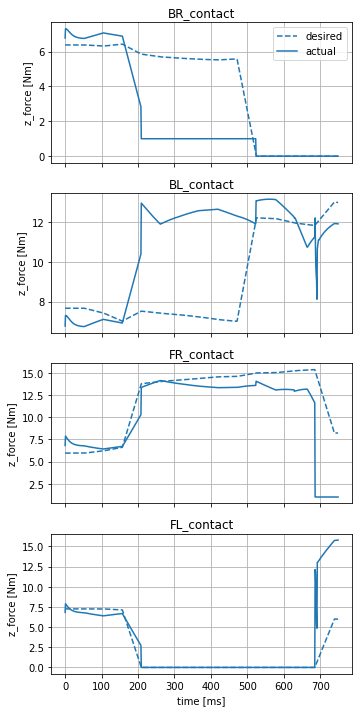

In [70]:
color = ['b', 'o', 'r', 'g']

['BR_contact', 'BL_contact', 'FR_contact', 'FL_contact']

fig, axes = plt.subplots(4, 1, figsize=(5, 10), sharex=True)

for i, ax in enumerate(axes):
    line = ax.plot(desired['forces'][:N_SIMULATION, 2::3][:, i], linestyle = '--', label='desired')[0]
    ax.plot(forces[:N_SIMULATION, 2::3][:, i], color = line.get_color(), linestyle = '-', label='actual')
    ax.set_title(contact_frames[i])
    
    if i == 0:
        ax.legend()

    ax.grid(True)
    ax.set_ylabel('z_force [Nm]')

axes[-1].set_xlabel('time [ms]')

fig.tight_layout()